## 利用GPT大型模型工具完成数据洞察
**本周以及下周的实验内容如下：**
请同学们参考《GPT数据科学系列课程实验手册》内容，并结合之前的作业经验，对GitHub上具有协作行为日志数据的500名用户的个人信息（包括姓名、公司、邮箱及其地理位置等）进行数据洞察分析。数据获取链接为：https://github.com/X-lab2017/dase-2024-autumn/tree/main/HomeWork/data/user_data

### 实验目标
- 培养数据处理与分析能力：通过实际操作，提升对大规模数据集的处理和分析能力。
- 掌握GPT工具的应用：学习如何利用GPT大型模型工具辅助完成数据洞察任务。
- 理解数据隐私与伦理：在处理包含个人信息的数据时，遵循数据隐私保护的原则和规范。
### 实验内容
1. 人口统计分析
- 国家和地区分布：统计用户所在国家和地区的分布，识别主要的开发者集中地。
- 城市级别分布：分析主要城市的开发者密度，发现技术热点区域。
- 时区分布:了解用户的时区分布，分析不同地区用户的协作时间模式。
2. 协作行为分析
- 提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。
3. 其他维度有趣的洞察（至少2个）
### 提交内容
- 数据分析代码。
- 最终的数据洞察报告（PDF格式）。

### 实验过程
（注. 仅包含数据分析相关代码与数据处理过程，由可视化图得到的数据洞察见[`HW12_report.pdf`](HW12_report.pdf)）
#### 1. 人口统计分析
首先考察一下各项指标的缺失值。

In [343]:
import pandas as pd

# 读取源文件
df = pd.read_csv('data/user_data/users_combined_info.csv')

# 查看缺失值
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_data_report = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': missing_values,
    'Missing Percentage (%)': missing_percent
})

# 输出结果
print(missing_data_report)

                          Column  Missing Values  Missing Percentage (%)
user_id                  user_id               0                0.000000
name                        name               0                0.000000
location                location               0                0.000000
total_influence  total_influence               0                0.000000
country                  country           88151                6.808205
event_type            event_type               0                0.000000
event_action        event_action               0                0.000000
event_time            event_time               0                0.000000


由上面的输出可见，`country`一栏的缺失值较多。我们需要对`country`列中存在缺失值的数据进行进一步洞察，检查它们的`location`列是否包含可用于推断`country`的信息。所以，我们输出所有`country`列缺失的条目的`location`值。

In [344]:
# 筛选出 'country' 列缺失值对应的条目
missing_country_data = df[df['country'].isnull()]

# 提取唯一的 'location' 值
missing_locations = set(missing_country_data['location'])

# 打印所有独特的 'location'
print("缺失的 'country' 对应的独特 'location' 如下：")
for location in missing_locations:
    print(location)


缺失的 'country' 对应的独特 'location' 如下：
The Blue Planet
ed25519/0x156B038E61A4C823
UTC+2
</>
.
Earth, Milky Way
GPS based...
Skies
0.0.0.0
Planet Earth
Ether
UTC+1
きさらぎ駅
Acheron, Hades
Everything everywhere all at once.
Barcelona
::1
Europe (CET)
The Nearest Event Horizon
Solar system
Earth
CYBERSPACE
I’m on earth right now.
Internet
localhost
European Union
The Internet
Ireland
$HOME
☁️
Lyoko
$PYTHONPATH
5 centimeters from the screen
Europe


让GPT分析所有上述的`location`值。下面四个值可以推断出`country`值，我们假设他们设置的`location`是正确的，用推断出的值补全`country`值。而其他的都是用户有意隐藏自己的真实地址而随意编写的名字，我们把他们的`country`值补全为`Unknown`。
- `Barcelona`: 明确提到的城市（在西班牙），可以用来补全 country = Spain。
- `Ireland`: 直接提供了国家名，可以用来补全 country = Ireland。
- `European Union`: 泛指欧洲地区，可以补全为一个通用值 country = Europe。
- `Europe (CET)`: 提到欧洲时区，可以补全为 country = Europe。

In [345]:
# country值补全
# 映射规则
location_to_country = {
    'Barcelona': 'Spain',
    'Ireland': 'Ireland',
    'European Union': 'Europe',
    'Europe (CET)': 'Europe'
}

# 补全逻辑：仅对 country 缺失的条目进行补充；如果 location 不在映射中，则映射为 'Unknown'
df['country'] = df.apply(
    lambda row: location_to_country.get(row['location'], 'Unknown') if pd.isnull(row['country']) else row['country'],
    axis=1
)

# 再次检查缺失值数量
remaining_missing_countries = df['country'].isnull().sum()
print(f"补全后，缺失的country值数：{remaining_missing_countries}")


补全后，缺失的country值数：0


接下来我们就可以统计各个国家的开发者总数了。绘制饼图展示各国家开发者的分布。为了让饼图更清晰，只展示开发者数量较多的国家，将其他国家合并为 "Others"。

由于数据文件中的每条记录代表的是开发者的活动，而不是一个开发者本身，因此统计时我们需要基于`user_id`去重，确保每个开发者只被统计一次。

下面给出了饼图和可交互的地图热力图，来描述各个国家的开发者数量。

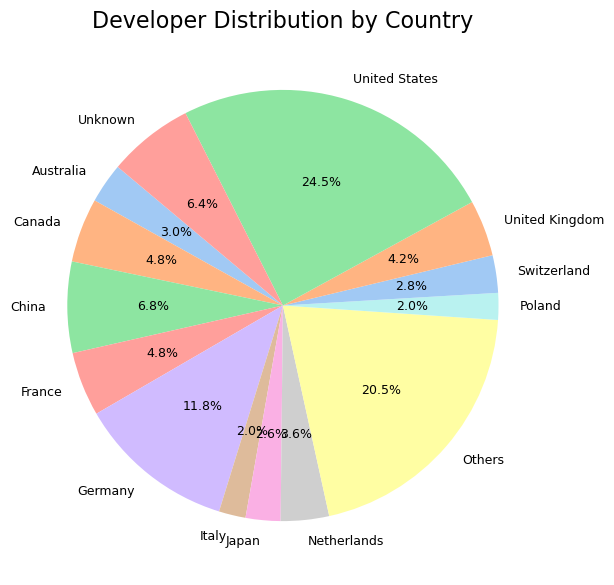

In [346]:
import seaborn as sns
import matplotlib.pyplot as plt

# 统计独立开发者总数（基于之前代码的结果）
unique_developers = df[['user_id', 'country']].drop_duplicates()
country_counts = unique_developers['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Developer Count']

# 将少于某个数量的国家归为 "Others"
threshold = 10  # 阈值：开发者数量少于该值的国家归为 "Others"
country_counts['Country'] = country_counts['Country'].apply(
    lambda x: x if country_counts[country_counts['Country'] == x]['Developer Count'].values[0] >= threshold else 'Others'
)

# 合并 "Others" 的数量
country_counts = country_counts.groupby('Country').sum().reset_index()

# 提取数据
sizes = country_counts['Developer Count']
labels = country_counts['Country']

# 设置颜色
colors = sns.color_palette('pastel', len(sizes))

# 绘制饼图
plt.figure(figsize=(10, 7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 9}  # 调整字体大小
)
plt.title('Developer Distribution by Country', fontsize=16)
plt.show()


In [347]:
import plotly.express as px
unique_developers = df[['user_id', 'country']].drop_duplicates()
# 准备国家开发者数据
country_counts = unique_developers['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Developer Count']

# 使用 Plotly 绘制地图
fig = px.choropleth(
    country_counts,
    locations='Country',
    locationmode='country names',  # 按国家名称匹配
    color='Developer Count',
    color_continuous_scale='OrRd',  # 热力图颜色
    title='Developer Distribution by Country'
)

# 显示地图
fig.update_layout(
    title_font_size=20,
    geo=dict(showframe=False, showcoastlines=True)
)
fig.show()


接下来，查看城市信息。

In [348]:
# 获取所有不重复的 location 信息
unique_locations = set(df['location'].dropna())

# 打印所有独特的 location 信息
print("所有独特的 location 信息如下：")
for location in sorted(unique_locations):  # 排序后打印，方便查看
    print(location)


所有独特的 location 信息如下：
$HOME
$PYTHONPATH
.
0.0.0.0
5 centimeters from the screen
::1
</>
Aaramoun, Lebanon
Acheron, Hades
Addis Ababa
America/Vancouver
Amherst, MA
Amsterdam
Amsterdam, NY, USA
Amsterdam, Netherlands
Amsterdam, The Netherlands
Appleton, WI
Arkansas, US
Arnhem
Astrakhan, Russia
Athens, Greece
Auckland, New Zealand
Austin, TX
Australia
Austria, Europe
Baltimore, MD, USA
Bandung, Indonesia
Barcelona
Bavaria, Germany
Beijing
Beijing China
Beijing, China
Belgium
Bend, OR
Berkeley, CA
Berlin
Berlin, Germany
Bogota
Boise ID
Bordeaux
Boston
Boston, USA
Bothell, WA
Boulder, CO
Brazil
Brisbane
Brisbane, Australia
Brooklyn, NY
Budapest, HU
CHN, Shandong
CYBERSPACE
California
Cambridge, MA
Canada
Canberra
Canberra, ACT, Australia
Canberra, Australia
Cape Town, South Africa
Cardiff, UK
Chengdu, Sichuan, China
Chicago, IL
China
Chongqing, China
Cologne
Colorado
Copenhagen
Copenhagen, Denmark
Cracow
Cuenca, Ecuador
Cupertino
Cupertino, CA
Czechia
Delaware (but Philly at heart)
Denmark
D

让GPT分析上述的所有`location`值。由于`location`的值格式千奇百怪，很难进行数据清洗。可以利用GPT强大的能力，让GPT给出一个由`location`到真实城市名称的一一映射，我们将其保存到`HW12_location_to_city.json`中。

注. 一些只给出国家名或无法推断出城市名的`location`值被映射到`Unknown`。

然后我们给出TOP16活跃城市的条形图。

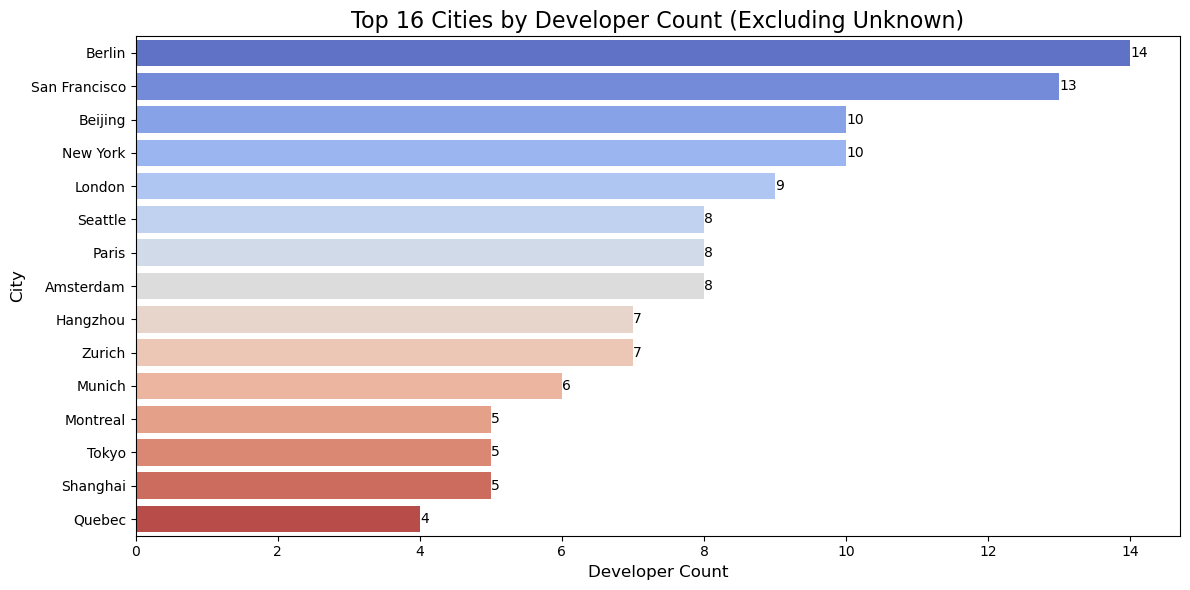

In [349]:
import pandas as pd
import re
import json

# 从 JSON 文件中加载映射
with open("HW12_location_to_city.json", "r", encoding="utf-8") as f:
    location_to_city = json.load(f)

 
# 使用映射创建 df['city'] 列
df['city'] = df['location'].map(location_to_city).fillna('Unknown')

# 去重数据，确保每个开发者只统计一次
unique_developers = df[['user_id', 'city']].drop_duplicates()

# 统计每个城市的开发者数量
city_counts = unique_developers['city'].value_counts().reset_index()
city_counts.columns = ['City', 'Developer Count']

# 排序城市排行榜
city_counts = city_counts.sort_values(by='Developer Count', ascending=False)
top_cities = city_counts.head(16)
top_cities = top_cities.reset_index(drop=True)

# 排除 "Unknown" 城市
top_cities_no_unknown = top_cities[top_cities['City'] != 'Unknown']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_cities_no_unknown,
    y='City',
    x='Developer Count',
    hue='City',  # 将 y 变量分配给 hue
    palette='coolwarm',
    dodge=False  # 禁止分组效果
)
plt.legend([], [], frameon=False)  # 禁用图例

# 添加标题和标签
plt.title("Top 16 Cities by Developer Count (Excluding Unknown)", fontsize=16)
plt.xlabel("Developer Count", fontsize=12)
plt.ylabel("City", fontsize=12)

# 显示具体数值在条形图旁
for index, value in enumerate(top_cities_no_unknown['Developer Count']):
    plt.text(value, index, f"{value}", va='center', ha='left', fontsize=10)

# 优化布局
plt.tight_layout()
plt.show()


对于时区相关分析，由于数据集中并不包括时区的相关信息，故我们要根据国家在数据集中自行补充其时区信息。我们先打印出所有`country`的取值，再构建起`country`到时区的一一映射。

In [350]:
# 打印所有 `country` 列的唯一取值
unique_countries = df['country'].dropna().unique()
print("Unique countries in the dataset:")
for country in sorted(unique_countries):
    print(country)

Unique countries in the dataset:
Australia
Austria
Belgium
Brazil
Bulgaria
Canada
China
Colombia
Czechia
Denmark
Ecuador
Egypt
Estonia
Ethiopia
Europe
Finland
France
Georgia
Germany
Greece
Hong Kong
Hungary
India
Indonesia
Ireland
Israel
Italy
Japan
Kenya
Lebanon
Lithuania
Malaysia
Netherlands
New Zealand
Norway
Pakistan
Poland
Portugal
Russia
Singapore
Slovenia
South Africa
South Korea
Spain
Sweden
Switzerland
Taiwan
Tunisia
Türkiye
United Arab Emirates
United Kingdom
United States
Unknown
Vietnam


下面绘制这500个开发者的时区分布条形图。

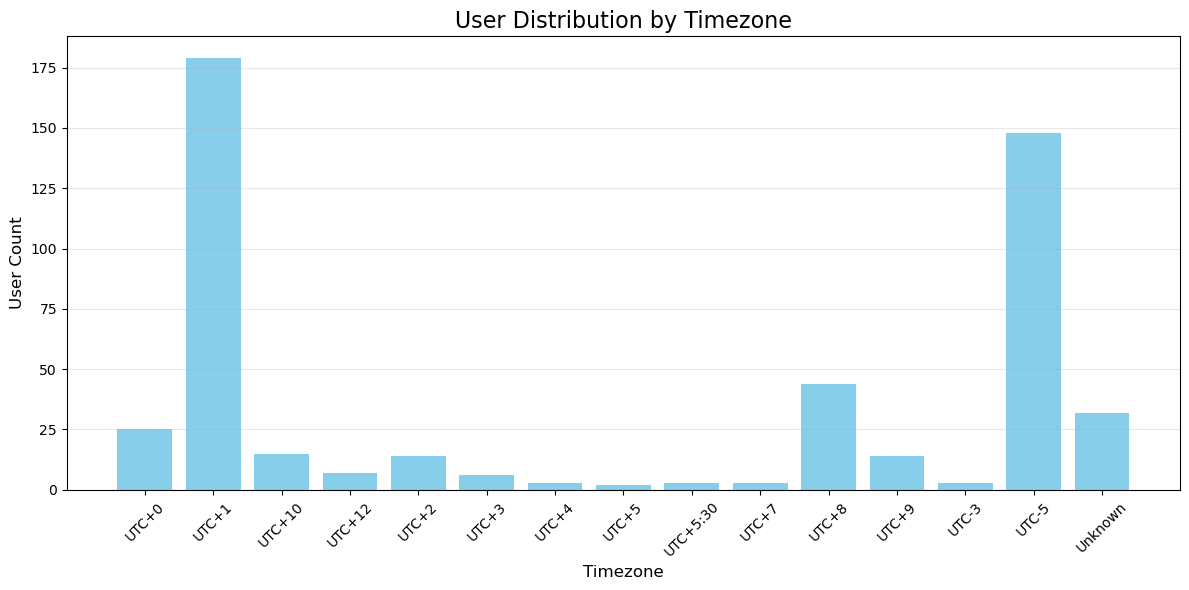

In [351]:
# 从 JSON 文件中加载国家到时区的映射
with open("HW12_country_to_timezone.json", "r", encoding="utf-8") as f:
    country_to_timezone = json.load(f)
# 使用映射补充时区信息
df['timezone'] = df['country'].map(country_to_timezone).fillna('Unknown')

# 对用户去重，确保统计的是独立用户
unique_users = df[['user_id', 'timezone']].drop_duplicates()

# 按时区统计独立用户数量
timezone_counts = unique_users['timezone'].value_counts().reset_index()
timezone_counts.columns = ['Timezone', 'User Count']

# 按时区递增排序
timezone_counts = timezone_counts.sort_values(by='Timezone')

# 绘制条形图
plt.figure(figsize=(12, 6))
plt.bar(timezone_counts['Timezone'], timezone_counts['User Count'], color='skyblue')
plt.xlabel("Timezone", fontsize=12)
plt.ylabel("User Count", fontsize=12)
plt.title("User Distribution by Timezone", fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

下面给出他们工作活动的气泡图。注意，第一个图纵轴是以UTC+8即北京时间为基准，而第二给图的纵轴的时间是各个时区分别对应的时间。

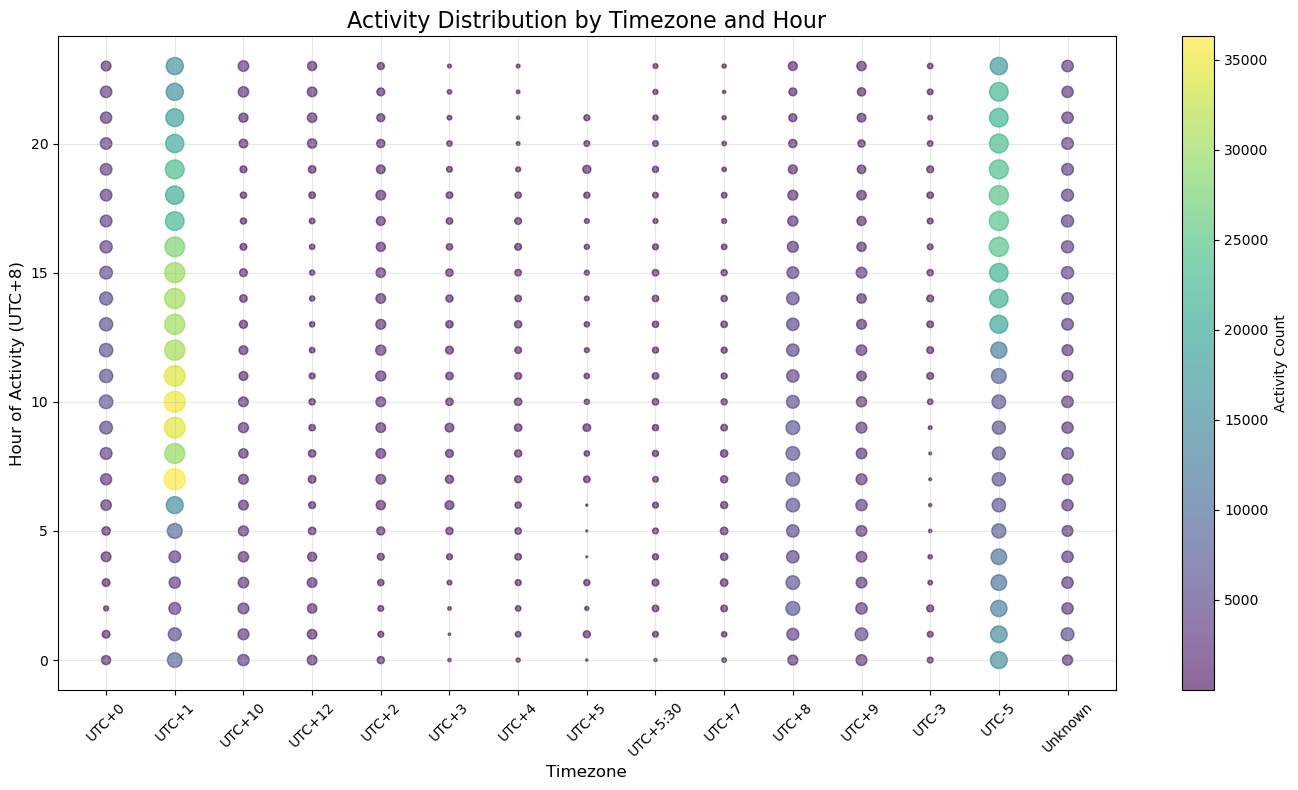

In [352]:
import numpy as np

# 提取活动时间的小时部分
df['event_hour'] = pd.to_datetime(df['event_time']).dt.hour

# 按时区和小时统计活动数量
activity_counts = df.groupby(['timezone', 'event_hour']).size().reset_index(name='Activity Count')

# 绘制气泡图
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    x=activity_counts['timezone'],
    y=activity_counts['event_hour'],
    s=np.sqrt(activity_counts['Activity Count']) * 1.2,  # 点的大小，数量越多点越大，用平方根来控制大小
    alpha=0.6,
    c=activity_counts['Activity Count'],  # 使用活动数量作为颜色的渐变值
    cmap='viridis'  # 颜色映射方案
)

# 添加颜色条以表示活动数量
plt.colorbar(scatter, label='Activity Count')

# 图表美化
plt.title("Activity Distribution by Timezone and Hour", fontsize=16)
plt.xlabel("Timezone", fontsize=12)
plt.ylabel("Hour of Activity (UTC+8)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()

# 展示气泡图
plt.show()

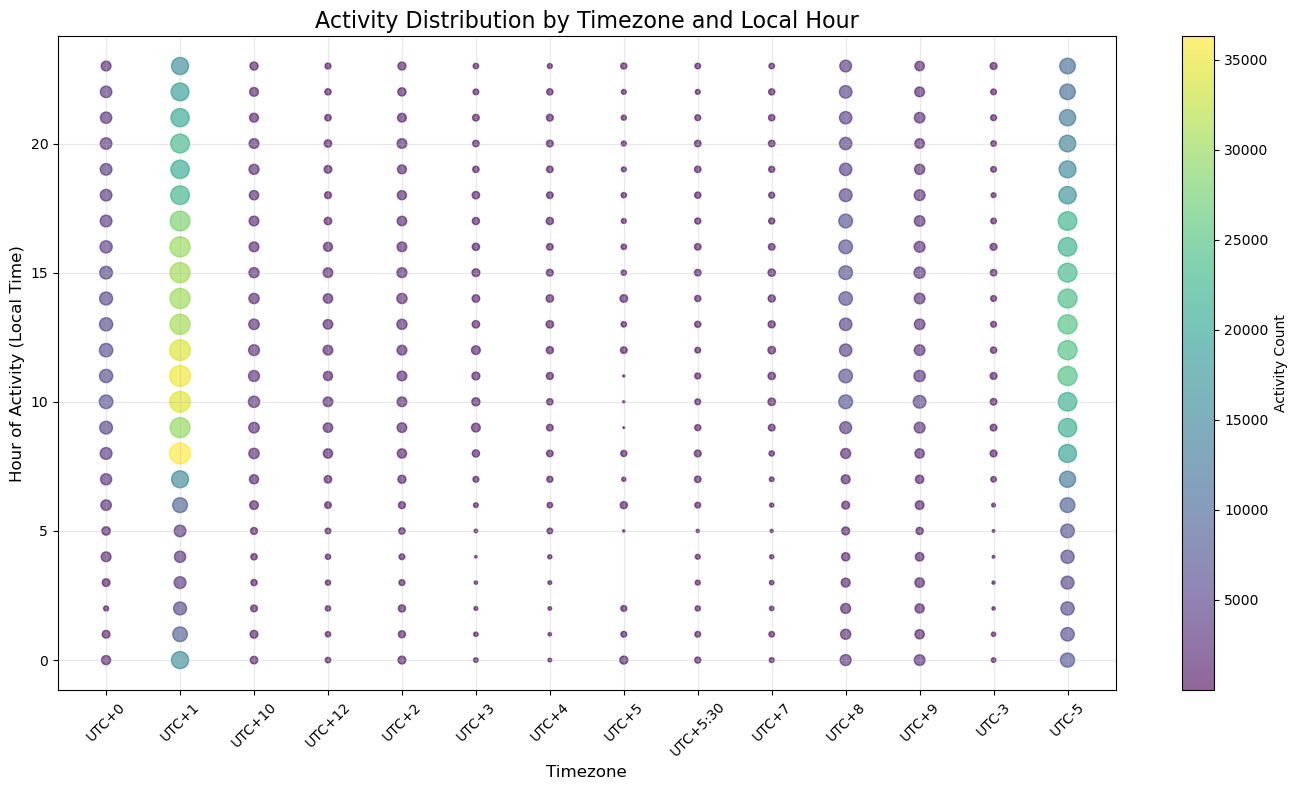

In [353]:
import numpy as np

# 提取活动时间的小时部分
df['event_hour'] = pd.to_datetime(df['event_time']).dt.hour

# 提取时区的偏移量并调整小时
# 假设时区的格式为 "UTC+X" 或 "UTC-X"
def adjust_to_local_hour(row):
    timezone = row['timezone']
    event_hour = row['event_hour']
    
    if timezone == "Unknown":  # 跳过未知时区
        return np.nan
    
    # 提取时区偏移量
    match = re.match(r'UTC([+-]\d+)', timezone)
    if match:
        offset = int(match.group(1))
        # 调整活动时间为本地时间
        local_hour = (event_hour + offset) % 24  # 确保时间为 0-23 小时
        return local_hour
    else:
        return np.nan

# 应用调整函数
df['local_event_hour'] = df.apply(adjust_to_local_hour, axis=1)

# 按时区和本地小时统计活动数量
activity_counts = df.groupby(['timezone', 'local_event_hour']).size().reset_index(name='Activity Count')

# 绘制气泡图
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    x=activity_counts['timezone'],
    y=activity_counts['local_event_hour'],
    s=np.sqrt(activity_counts['Activity Count']) * 1.2,  # 点的大小，数量越多点越大，用平方根来控制大小
    alpha=0.6,
    c=activity_counts['Activity Count'],  # 使用活动数量作为颜色的渐变值
    cmap='viridis'  # 颜色映射方案
)

# 添加颜色条以表示活动数量
plt.colorbar(scatter, label='Activity Count')

# 图表美化
plt.title("Activity Distribution by Timezone and Local Hour", fontsize=16)
plt.xlabel("Timezone", fontsize=12)
plt.ylabel("Hour of Activity (Local Time)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()

# 展示气泡图
plt.show()

### 2.协作行为分析
提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。

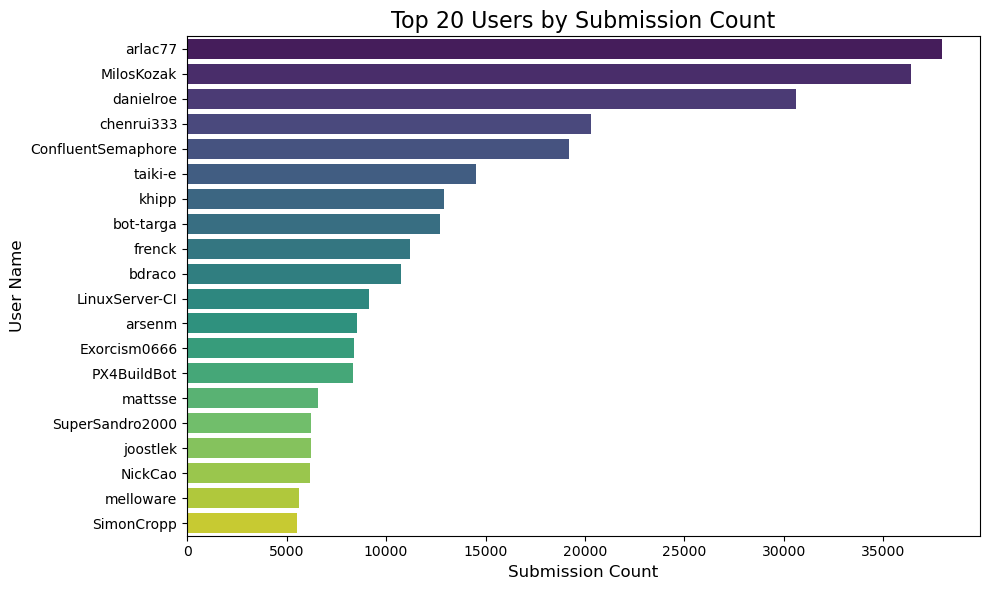

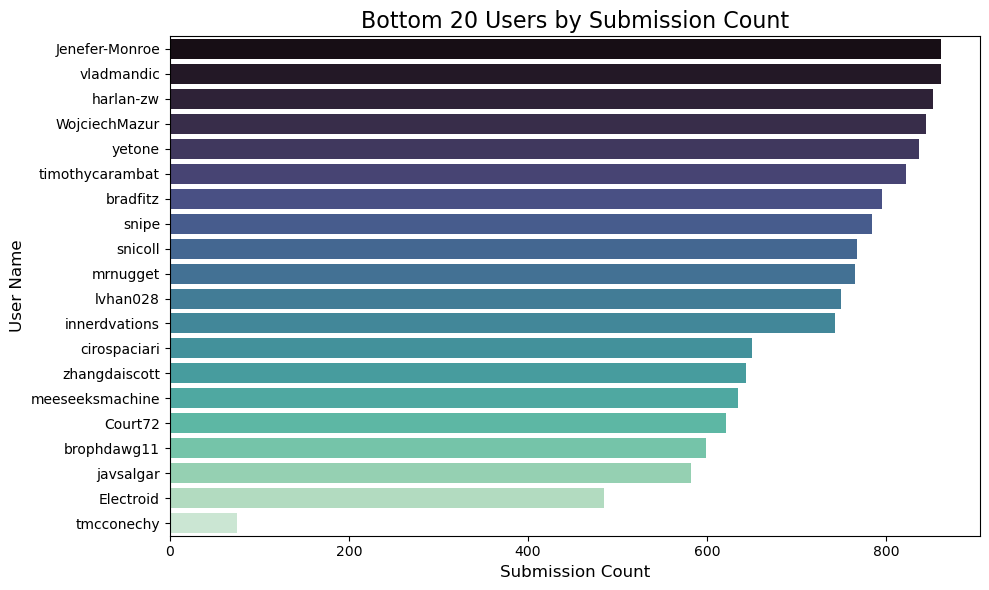

In [354]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

# 统计每个用户的提交次数
user_activity = df['name'].value_counts().reset_index()
user_activity.columns = ['name', 'Submission Count']

# 取前20名用户和末尾20名用户
top_users = user_activity.head(20)
bottom_users = user_activity.tail(20)

# 绘制前20名用户
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_users['name'], 
    x=top_users['Submission Count'], 
    hue=top_users['name'],  # 将 name 映射到颜色调色板
    dodge=False,  # 禁用分组
    palette='viridis', 
    legend=False  # 禁用图例
)
plt.title("Top 20 Users by Submission Count", fontsize=16)
plt.xlabel("Submission Count", fontsize=12)
plt.ylabel("User Name", fontsize=12)
plt.tight_layout()
plt.show()

# 绘制末尾20名用户
plt.figure(figsize=(10, 6))
sns.barplot(
    y=bottom_users['name'], 
    x=bottom_users['Submission Count'], 
    hue=bottom_users['name'],  # 将 name 映射到颜色调色板
    dodge=False, 
    palette='mako', 
    legend=False
)
plt.title("Bottom 20 Users by Submission Count", fontsize=16)
plt.xlabel("Submission Count", fontsize=12)
plt.ylabel("User Name", fontsize=12)
plt.tight_layout()
plt.show()


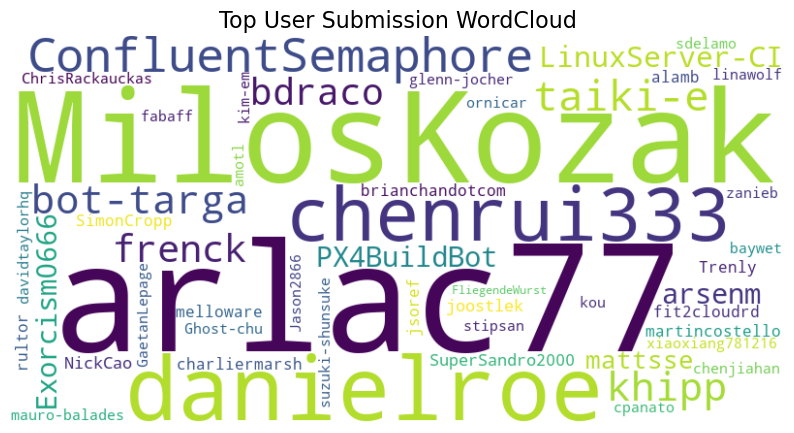

In [355]:
from wordcloud import WordCloud

# 构造词云数据：用户ID -> 提交次数
wordcloud_data = {str(row['name']): row['Submission Count'] for _, row in user_activity.head(50).iterrows()}

# 生成词云
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

# 绘制词云
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top User Submission WordCloud", fontsize=16)
plt.show()


### 3.其他维度有趣的观察
(1)用户影响力榜单：

In [356]:
# 统计每个用户的平均影响力、国家和地区
user_stats = df.groupby('name', as_index=False).agg({
    'total_influence': 'mean',  # 平均影响力
    'location': 'first'         # 用户的地区
})

# 排序并提取影响力前10名用户
top_influence_users = user_stats.sort_values(by='total_influence', ascending=False).head(10)
# 重置索引
top_influence_users_reset = top_influence_users.reset_index(drop=True)

# 打印结果
print("Top 10 Users by Total Influence:")
print(top_influence_users_reset)



Top 10 Users by Total Influence:
              name  total_influence                       location
0           bdraco      1776.967163                    Houston, TX
1           Koenkk      1674.805908       The Netherlands, Helmond
2           fabaff      1590.152954                    Switzerland
3    charliermarsh      1580.198242                   Brooklyn, NY
4           frenck      1520.352173      Enschede, The Netherlands
5     glenn-jocher      1392.865723             Spain ⇄ California
6  SuperSandro2000      1220.031738                        Germany
7         joostlek      1219.017944       Utrecht, The Netherlands
8    mauro-balades      1201.465759  5 centimeters from the screen
9          NickCao      1120.395699                         Boston


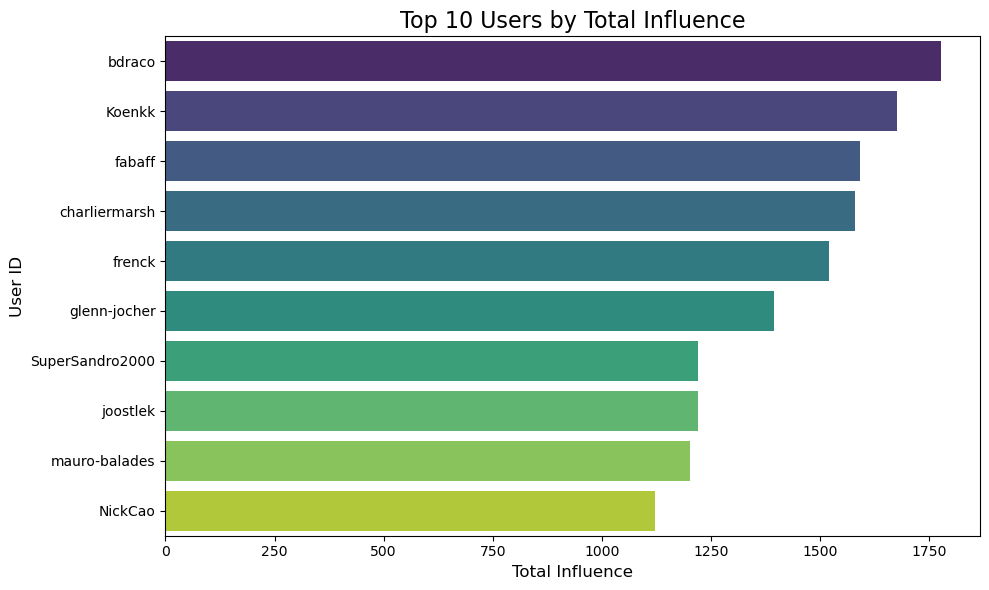

In [357]:
# 绘制影响力 TOP 10 排行榜
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_influence_users['name'], 
    x=top_influence_users['total_influence'], 
    palette='viridis',
    hue=top_influence_users['name'],  # 设置 hue 为 y 轴变量
    dodge=False,  # 禁止分组
    legend=False  # 禁用图例
)
plt.title("Top 10 Users by Total Influence", fontsize=16)
plt.xlabel("Total Influence", fontsize=12)
plt.ylabel("User ID", fontsize=12)
plt.tight_layout()
plt.show()

(2) 工作日与周末的日均活动数目与活动时间对比：

注意，数据集里所有活动时间是基于UTC+8的，因此我们需要将活动时间转换为本地时间。

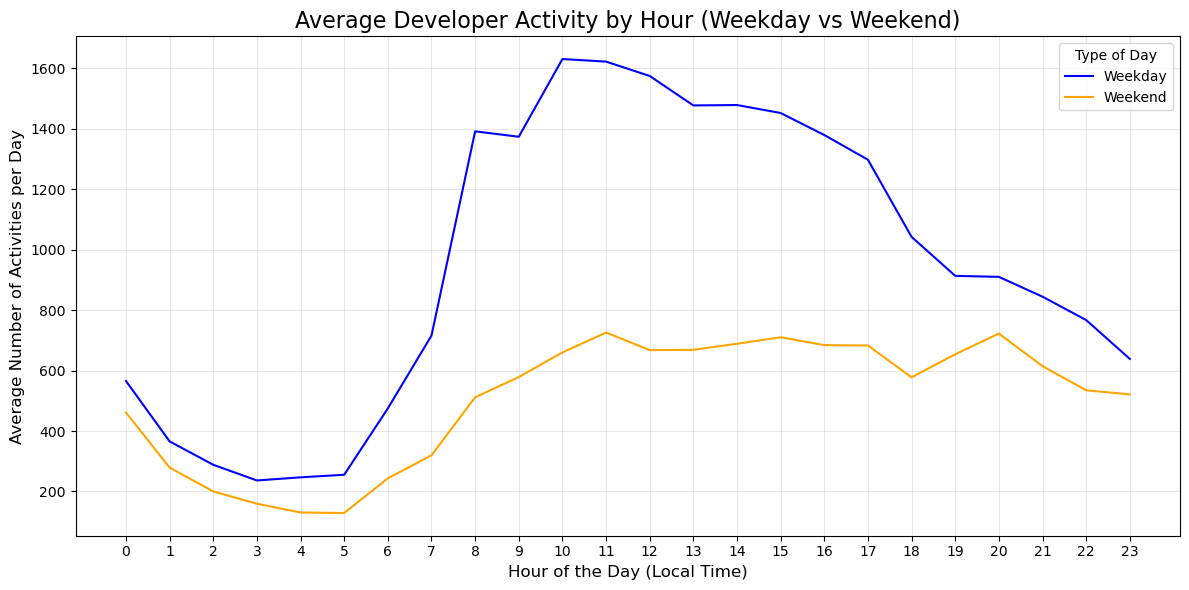

In [362]:
# 提取活动时间的小时部分
df['event_hour'] = pd.to_datetime(df['event_time']).dt.hour

# 调整为本地时间
def adjust_to_local_hour(row):
    timezone = row['timezone']
    event_hour = row['event_hour']
    
    if timezone == "Unknown":  # 跳过未知时区
        return np.nan
    
    # 提取时区偏移量
    match = re.match(r'UTC([+-]\d+)', timezone)
    if match:
        offset = int(match.group(1))
        # 调整活动时间为本地时间
        local_hour = (event_hour + offset) % 24  # 确保时间为 0-23 小时
        return local_hour
    else:
        return np.nan

# 应用调整函数
df['local_event_hour'] = df.apply(adjust_to_local_hour, axis=1)

# 提取日期并标记工作日/周末（按本地时间）
df['event_date'] = pd.to_datetime(df['event_time']).dt.date
df['is_weekend'] = pd.to_datetime(df['event_date']).dt.dayofweek >= 5  # 周六/周日标记为 True

# 计算工作日和周末的天数
num_weekdays = len(df[df['is_weekend'] == False]['event_date'].unique())  # 工作日天数
num_weekends = len(df[df['is_weekend'] == True]['event_date'].unique())   # 周末天数

# 统计每小时活动数量并计算日均提交量
hourly_activity_weekday = df[df['is_weekend'] == False]['local_event_hour'].value_counts().sort_index() / num_weekdays
hourly_activity_weekend = df[df['is_weekend'] == True]['local_event_hour'].value_counts().sort_index() / num_weekends

# 绘制工作日与周末的对比图（以日均提交量为纵轴）
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_activity_weekday.index, y=hourly_activity_weekday.values, label='Weekday', color='blue')
sns.lineplot(x=hourly_activity_weekend.index, y=hourly_activity_weekend.values, label='Weekend', color='orange')
plt.title("Average Developer Activity by Hour (Weekday vs Weekend)", fontsize=16)
plt.xlabel("Hour of the Day (Local Time)", fontsize=12)
plt.ylabel("Average Number of Activities per Day", fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title="Type of Day")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



(3) 分析event_type字段中事件种类的分布并绘制饼状图：

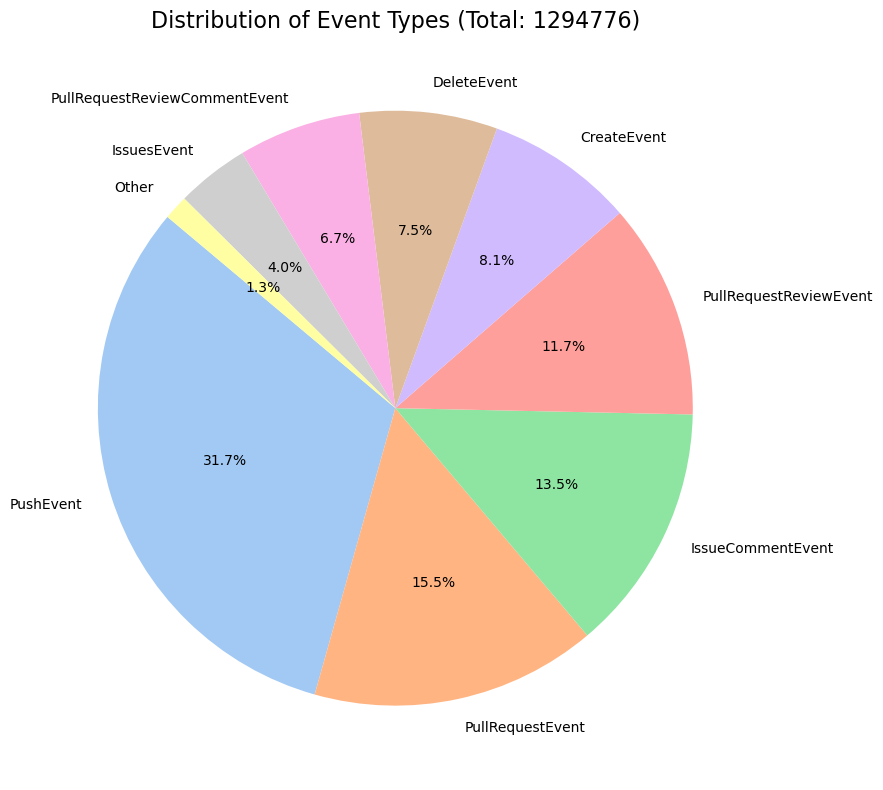

In [363]:
# 统计每种事件类型的数量
event_type_distribution = df['event_type'].value_counts()

# 计算事件类型的百分比
total_events = event_type_distribution.sum()
event_type_percent = (event_type_distribution / total_events) * 100

# 将低于 2% 的类型归为 "Other"
event_type_distribution_adjusted = event_type_distribution.copy()
event_type_distribution_adjusted[event_type_percent < 2] = 0  # 设置为 0 后合并到 "Other"
event_type_distribution_adjusted["Other"] = event_type_distribution[event_type_percent < 2].sum()

# 删除原来的小类别
event_type_distribution_adjusted = event_type_distribution_adjusted[event_type_distribution_adjusted > 0]

# 绘制调整后的饼状图
plt.figure(figsize=(10, 8))
plt.pie(
    event_type_distribution_adjusted.values, 
    labels=event_type_distribution_adjusted.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel', len(event_type_distribution_adjusted))
)
plt.title(f"Distribution of Event Types (Total: {total_events})", fontsize=16)
plt.tight_layout()
plt.show()
